# Initialisation and Dependencies

In [1]:
import sys
lib_path = '/home/jovyan/libs'
sys.path.insert(0, lib_path)

In [2]:
import gc, math, traceback, datetime

import numpy as np

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from datasets import load_from_disk

from transformers import WhisperForConditionalGeneration, WhisperProcessor

from tqdm import tqdm

from utils import audio, training
from utils.attacks import PrepareMethod, PrepareFront

from typing import Optional

# GPU RAM Tracking

In [3]:
def print_cuda_usage(msg: str = ""):
    if torch.cuda.is_available():
        print(f"{msg}{torch.cuda.memory_allocated(0)/(1024 ** 3)} GB")

def get_cuda_usage():
    return torch.cuda.memory_allocated(0)/(1024 ** 3)

In [4]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

In [5]:
device

'cuda'

# Load Models

In [6]:
try:
    del clean_model
    del corrupted_model
    print("Models deleted!")
except:
    pass

In [34]:
MODEL_NAME = "tiny.en"

clean_model = WhisperForConditionalGeneration.from_pretrained(f"openai/whisper-{MODEL_NAME}", local_files_only=True).cuda()
corrupted_model = WhisperForConditionalGeneration.from_pretrained(f"openai/whisper-{MODEL_NAME}", local_files_only=True).cuda()
processor = WhisperProcessor.from_pretrained(f"openai/whisper-{MODEL_NAME}", local_files_only=True)
eos_id = processor.tokenizer.eos_token_id

clean_model.eval()
corrupted_model.eval()

print("Done")

Done


# Load Data

In [35]:
tedlium_path = "../tedlium"
path = f"{tedlium_path}/test.hf"

In [36]:
SELECT = 100

SEED = 1

data = load_from_disk(path).with_format("torch").shuffle(seed=SEED).select(range(SELECT))

In [37]:
# def collate(ls):
#     pad_to = max(list(map(lambda x: x["audio"].shape[0], ls)))
#     return torch.cat(list(map(lambda x: F.pad(x["audio"], (0, pad_to - x["audio"].shape[0])).unsqueeze(0).to(torch.bfloat16), ls)), dim=0)

# def collate_idx(ls):
#     return ls[0]["audio"].unsqueeze(0), ls[0]["idx"].item()

# TRAIN_BATCH_SIZE = 1 # highly recommended to be 1

# train_dataset = DataLoader(tedlium_train, batch_size=TRAIN_BATCH_SIZE, collate_fn=collate_idx)

# Register Hooks

In [38]:
activations = {}
debug_activations = {}
hooks = []
temp_hooks = []
activation_count = [0]

In [39]:
def reset():
    remove_hook_list(hooks)
    remove_hook_list(temp_hooks)
        
    activations.clear()
    debug_activations.clear()

def remove_hook_list(hook_list):
    for h in hook_list:
        h.remove()
    
    hook_list.clear()

def append_dict(d, k, value):
    temp = d.get(k, [])
    temp.append(value)
    d[k] = temp
    
# for clean run
def clean_hook(idx, d):
    def hook(module, args, output):
        append_dict(d, idx, output)
        return output
    return hook

def corrupted_hook_embed(alpha=1):
    def hook(module, args, output):
        epsilons = torch.normal(0, alpha * torch.std(output.squeeze()).item(), size=tuple(output.shape)).to(output.device)
        assert output.shape == (output + epsilons).shape, "ERROR"
        return output + epsilons
    return hook

def corrupted_hook_with_correction(block, token):
    def hook(module, args, out):
        activation_count[0] += 1
        if activation_count[0] == token:
            out = activations[block][token]
        return out
    return hook

In [40]:
def register_hooks_by_block(model, hook_creator, d, hl):
    """
    The parameter hook should be a function that returns a hook function
    """
    for i, block in enumerate(model.model.decoder.layers):
        hook_i = hook_creator(i, d)
        h = block.register_forward_hook(hook_i)
        hl.append(h)
        
def register_hook_at_block(model, block, token, hl):
    h = model.model.decoder.layers[block].register_forward_hook(corrupted_hook_with_correction(block, token))
    hl.append(h)
    return h

def register_hook_at_embedding(model, hook_creator, hl, alpha=1):
    h = model.model.decoder.embed_tokens.register_forward_hook(hook_creator(alpha))
    hl.append(h)

# Inference

In [41]:
def infer_with_probs(audio, model, processor):
    inputs = processor(audio, return_tensors="pt", sampling_rate=16_000)
    input_features = inputs.input_features.to(model.device)
    
    res = model.generate(input_features, return_dict_in_generate=True, output_scores=True)
    eos_probs = torch.tensor([torch.nn.Softmax(dim=0)(s.squeeze())[eos_id] for s in res["scores"]]) # get eos id for each token
    
    decoded = processor.decode(res.sequences.squeeze(), skip_special_tokens=True)
    return decoded, res, eos_probs

# Establish Clean Hooks

In [119]:
reset()

In [120]:
register_hooks_by_block(clean_model, clean_hook, activations, hooks)

In [121]:
example = data[20]
wave = example["audio"]
example["text"]

'and some fish meals and then he said chicken pellets'

In [122]:
decoded, res, eos_probs = infer_with_probs(wave, clean_model, processor)
decoded

' and some fish meals and then he said chicken pellets.'

In [174]:
original_probs = eos_probs.unsqueeze(1).repeat(1, 4) # to be used in finding effect

In [124]:
assert activations, "Activations is empty! Reverify"

# Corrupt Model and Run

In [125]:
# Verify model is sane before inserting hook
dd, rr, p = infer_with_probs(wave, corrupted_model, processor)
dd, p

(' and some fish meals and then he said chicken pellets.',
 tensor([0.0000e+00, 4.2728e-05, 3.6651e-06, 2.8615e-06, 2.3279e-04, 7.3043e-05,
         1.1265e-04, 1.8888e-05, 1.1879e-04, 4.4060e-04, 1.6771e-01, 9.9249e-01]))

In [126]:
embed_hook = register_hook_at_embedding(corrupted_model, corrupted_hook_embed, hooks, alpha=3)

In [127]:
dd, rr, p = infer_with_probs(wave, corrupted_model, processor)
dd

','

In [164]:
# rr

# Causal Tracing

In [53]:
results = []
temp_holder = []

try:
    for token in range(len(activations[0])):
        blocks = []
        for block in range(4):
            activation_count = [0]
            _, _, eos_prob_without_attack = infer_with_probs(wave, corrupted_model, processor)
            correction_hook = register_hook_at_block(corrupted_model, block, token, temp_holder)
            _, _, eos_prob = infer_with_probs(wave, corrupted_model, processor)
            correction_hook.remove()
            temp_holder.clear()
            blocks.append(eos_prob[1]) # eos prob for 1st token..?
        results.append(torch.stack(blocks))
        print(f"Token {token + 1}/{len(activations[0])}")
except Exception as e:
    correction_hook.remove()
    traceback.print_exc()

Token 1/12
Token 2/12
Token 3/12
Token 4/12
Token 5/12
Token 6/12
Token 7/12
Token 8/12
Token 9/12
Token 10/12
Token 11/12
Token 12/12


In [54]:
results_stacked = torch.stack(results)

In [173]:
results_stacked.shape

torch.Size([12, 4])

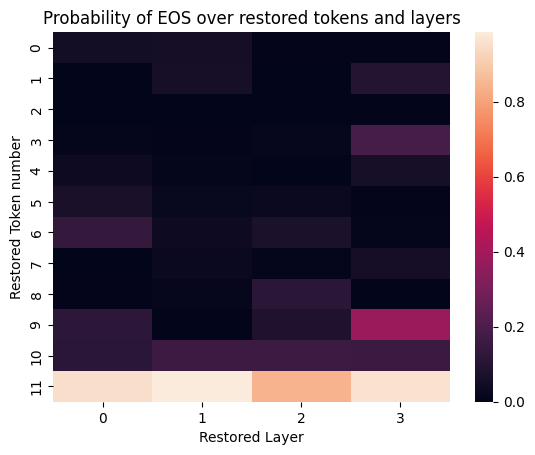

In [176]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax = sns.heatmap(torch.abs(results_stacked - original_probs), ax=ax)
ax.set_xlabel("Restored Layer")
ax.set_ylabel("Restored Token number")
ax.set_title("Probability of EOS over restored tokens and layers")
plt.show()